In [1]:
import os
import sys
import torch
from visual import *
import thinker.util as util
import matplotlib.pyplot as plt
from argparse import Namespace
import json
import csv
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as mtick

class RetBuffer:
    def __init__(self, max_actor_id, mean_n=400):
        """
        Compute the trailing mean return by storing the last return for each actor
        and average them;
        Args:
            max_actor_id (int): maximum actor id
            mean_n (int): size of data for computing mean
        """
        buffer_n = mean_n // max_actor_id + 1
        self.return_buffer = np.zeros((max_actor_id, buffer_n))
        self.return_buffer_pointer = np.zeros(
            max_actor_id, dtype=int
        )  # store the current pointer
        self.return_buffer_n = np.zeros(
            max_actor_id, dtype=int
        )  # store the processed data size
        self.max_actor_id = max_actor_id
        self.mean_n = mean_n
        self.all_filled = False

    def insert(self, returns, actor_ids):
        """
        Insert new returnss to the return buffer
        Args:
            returns (tuple): tuple of float, the return of each ended episode
            actor_ids (tuple): tuple of int, the actor id of the corresponding ended episode
        """
        # actor_id is a tuple of integer, corresponding to the returns
        if len(returns) == 0:
            return
        assert len(returns) == len(actor_ids)
        for r, actor_id in zip(returns, actor_ids):
            # Find the current pointer for the actor
            if actor_id >= self.max_actor_id:
                continue
            pointer = self.return_buffer_pointer[actor_id]
            # Update the return buffer for the actor with the new return
            self.return_buffer[actor_id, pointer] = r
            # Update the pointer for the actor
            self.return_buffer_pointer[actor_id] = (
                pointer + 1
            ) % self.return_buffer.shape[1]
            # Update the processed data size for the actor
            self.return_buffer_n[actor_id] = min(
                self.return_buffer_n[actor_id] + 1, self.return_buffer.shape[1]
            )

        if not self.all_filled:
            # check if all filled
            self.all_filled = np.all(
                self.return_buffer_n >= self.return_buffer.shape[1]
            )

    def insert_raw(self, episode_returns, ind, actor_id, done):
        episode_returns = episode_returns[done][:, ind]
        episode_returns = tuple(episode_returns.detach().cpu().numpy())
        done_ids = actor_id.broadcast_to(done.shape)[done]
        done_ids = tuple(done_ids.detach().cpu().numpy())
        self.insert(episode_returns, done_ids)

    def get_mean(self):
        """
        Compute the mean of the returns in the buffer;
        """
        if self.all_filled:
            overall_mean = np.mean(self.return_buffer)
        else:
            # Create a mask of filled items in the return buffer
            col_indices = np.arange(self.return_buffer.shape[1])
            # Create a mask of filled items in the return buffer
            filled_mask = (
                col_indices[np.newaxis, :] < self.return_buffer_n[:, np.newaxis]
            )
            if np.any(filled_mask):
                # Compute the sum of returns for each actor considering only filled items
                sum_returns = np.sum(self.return_buffer * filled_mask)
                # Compute the mean for each actor by dividing the sum by the processed data size
                overall_mean = sum_returns / np.sum(filled_mask.astype(float))
            else:
                overall_mean = 0.0
        return overall_mean

def read_run(path, mean_n=200, log_freq=250000, tran=False):
    max_actor_id = 32
    print("Reading %s max_actor_id %d" % (path, max_actor_id))
    ret_buffer = RetBuffer(max_actor_id, mean_n)
    csv_file = path
    step = log_freq
    steps, returns = [], []
    with open(csv_file, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            done_ids = eval(row["done_ids"])
            episode_returns = eval(row["episode_returns"])
            if tran:
                episode_returns = tuple(float(r > 10) for r in episode_returns)
            ret_buffer.insert(episode_returns, done_ids)
            if eval(row["real_step"]) >= step:
                steps.append(step)
                returns.append(ret_buffer.get_mean())
                step += log_freq
    return steps, returns

# main Sokoban results
base_path = "/home/schk/rebuttal/baseline_sokoban"
runs = [
    "v13_0.7b6",
    "v13_0.7b6_r1",
    "v13_0.7b6_r2",
    "v13_0.7b6_r3",
    "v13_0.7b6_r4",
    "v13_b_drc_0.7b6",
    "v13_b_drc_0.7b6_r4",
    "v13_b_drc_0.7b6_r5",    
]
scores_sokoban = {}
for run in runs:
    path = os.path.join(base_path, run+".csv")
    scores_sokoban[run] = read_run(path, mean_n=100, tran=True)

Reading /home/schk/rebuttal/baseline_sokoban/v13_0.7b6.csv max_actor_id 32
Reading /home/schk/rebuttal/baseline_sokoban/v13_0.7b6_r1.csv max_actor_id 32
Reading /home/schk/rebuttal/baseline_sokoban/v13_0.7b6_r2.csv max_actor_id 32
Reading /home/schk/rebuttal/baseline_sokoban/v13_0.7b6_r3.csv max_actor_id 32
Reading /home/schk/rebuttal/baseline_sokoban/v13_0.7b6_r4.csv max_actor_id 32
Reading /home/schk/rebuttal/baseline_sokoban/v13_b_drc_0.7b6.csv max_actor_id 32
Reading /home/schk/rebuttal/baseline_sokoban/v13_b_drc_0.7b6_r4.csv max_actor_id 32
Reading /home/schk/rebuttal/baseline_sokoban/v13_b_drc_0.7b6_r5.csv max_actor_id 32


In [62]:
def s_read_run(path, mean_n=1, log_freq=250000):
    print("Reading %s" % path)
    step = log_freq
    steps, returns, all_returns = [], [], []
    with open(path, newline="") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:     
            cur_step, score = float(row[0]), float(row[1])
            all_returns.append(score)
            if cur_step >= step:
                steps.append(cur_step)
                returns.append(np.average(all_returns[-mean_n:]))                
                step = cur_step + log_freq
    return steps, returns

runs = ["drc", "muzero", "resnet", "i2a", "ATreeC", "vin"]
for run in runs:
    path = os.path.join(base_path, run+".csv")
    scores_sokoban[run] = s_read_run(path, mean_n=5)


Reading /home/schk/rebuttal/baseline_sokoban/drc.csv
Reading /home/schk/rebuttal/baseline_sokoban/muzero.csv
Reading /home/schk/rebuttal/baseline_sokoban/resnet.csv
Reading /home/schk/rebuttal/baseline_sokoban/i2a.csv
Reading /home/schk/rebuttal/baseline_sokoban/ATreeC.csv
Reading /home/schk/rebuttal/baseline_sokoban/vin.csv


In [63]:
run = "dreamer1"
path = os.path.join(base_path, run+".jsonl")
mean_n=200
log_freq=250000

def j_read_run(path, mean_n=200, log_freq=250000, max_len=5e7):
    with open(path, 'r') as json_file:
        json_list = list(json_file)

    step = log_freq
    steps, returns, all_returns = [], [], []
    for json_str in json_list:
        result = json.loads(json_str)
        if 'episode/score' in result.keys():        
            cur_step, score = float(result['step']), float(result['episode/score'] > 5.)
            all_returns.append(score)
            if cur_step >= step:
                steps.append(cur_step)
                returns.append(np.average(all_returns[-mean_n:]))                
                step = cur_step + log_freq
                if step > max_len: break
    return steps, returns

runs = ["dreamer1"]
for run in runs:
    path = os.path.join(base_path, run+".jsonl")
    scores_sokoban[run] = j_read_run(path)

In [2]:
def plot(
    xs,
    ys,
    labels,
    mv_ns=None,
    xlim=None,
    size=1,
    xlabel="Frames",
    ylabel="Solving Rate",
    saveimg="",
    linestyle="",
    per=True,
    title=None,
    ax=None,    
    plot_std=False,
    legend=True
):
    if ax is None:
        plt.figure(figsize=(5 * size, 3.5 * size), dpi=80)
        ax = plt.gca()
    cmap = plt.get_cmap("tab10")
    for n, label in enumerate(labels):
        y = np.array(ys[n])    
        if mv_ns is not None: mv_n = mv_ns[n]
        if per: y = y * 100        
        if mv_ns is not None and mv_n > 1: 
            y = [np.concatenate([np.full([mv_n-1,],np.nan), mv(k, mv_n)]) for k in y]
            y = np.array(y)
        mean = np.mean(y, axis=0)
        std = np.std(y, axis=0)
        c = cmap(n)
        ax.plot(xs[n], mean, linestyle, label=label, color=c)       
        c = tuple(i * 0.3 + 0.7 for i in c)
        if plot_std:
            ax.fill_between(xs[n], mean - std, mean + std, label=None, color=c)
    if xlim is not None: ax.set_xlim([0, xlim])
    if legend: ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if per:
        fmt = "%.0f%%"
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    else:
        ax.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    plt.tight_layout()
    if saveimg:
        plt.savefig(saveimg, dpi=300, bbox_inches="tight")
    if title is not None:
        ax.set_title(title)
    return ax

def mv(a, n=10) :
  ret = np.cumsum(a, dtype=float)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n    


In [ ]:

results = {
    "Thinker": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2", "v13_0.7b6_r3", "v13_0.7b6_r4"],
    "DRC": ["v13_b_drc_0.7b6", "v13_b_drc_0.7b6_r4", "v13_b_drc_0.7b6_r5"],    
    "DRC (original paper)": ["drc"],    
    "Dreamer-v3": ["dreamer1"],
    "MuZero": ["muzero"],
    "ResNet": ["resnet"],
    "I2A": ["i2a"],
    "ATreeC": ["ATreeC"],
    "VIN": ["vin"]
}
saveimg = "/home/schk/rebuttal/a2.eps"

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []    
    max_len = 0
    for n, r in enumerate(rs):        
        new_y = scores_sokoban[r][1]        
        if n == 0:
            max_len = len(new_y)
        else:
            new_y = new_y[:max_len]
        y.append(new_y)
    ys.append(np.array(y))    
    if label in ["Thinker", "DRC"]: ys[-1] = ys[-1] + 0.01 
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)
    for thres in [2e7, 5e7-1e6]:
        ind = np.argmax(np.array(xs[-1]) >= thres)
        mean = np.average(ys[-1][:, ind])
        print("%s \t %d \t %4f" % (label, int(thres), mean))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))  # Two subplots
ax = plt.gca()
plot(xs, ys, labels, mv_ns=[3,3,1,15,1,1,1,1,1], ax=ax1, saveimg=saveimg, xlim=5e7, legend=False)
plot(xs, ys, labels, mv_ns=[6,6,1,12,1,1,1,1,1], ax=ax2, saveimg=saveimg, xlim=5e8, legend=False)

def reorder_for_legend(lines, labels, rows=2, cols=5):
    nsort = np.arange(rows*cols).reshape(rows, cols)
    rorder = []
    for col in range(cols):
        for row in range(rows):
            rorder.append(nsort[row, col])            
    rorder = rorder[:len(lines)]
    reordered_lines = [lines[x] for x in rorder]
    reordered_labels = [labels[x] for x in rorder]
    return reordered_lines, reordered_labels

lines, labels = fig.axes[-1].get_legend_handles_labels()
lines, labels = reorder_for_legend(lines, labels)
fig.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.55, -0.15), ncol=5)

ax1.text(0.02, 0.98, "Thinker's performance at 5e7", transform=ax1.transAxes, ha='left', va='top', fontsize=10)
ax1.axhline(y=94.5, color='b', label="Thinker's final performance", linestyle="--")
ax2.axhline(y=94.5, color='b', label="Thinker's final performance", linestyle="--")
plt.tight_layout()
plt.savefig(saveimg, dpi=300, bbox_inches="tight")
plt.show()

In [112]:
runs = [
    "v13_0.7b6_dirloss",
    "v13_0.7b6_dirloss_r2",
    "v13_0.7b6_dirloss_r3",
    "v13_0.7b6_noduel_r1",
    "v13_0.7b6_noduel_r2",
    "v13_0.7b6_noduel_r3",
    "v13_0.7b6_randim",
    "noduel_base_l2obs_8",
]
log_path = "/home/schk/rebuttal/logs"
for run in runs:
    path = os.path.join(log_path, run, "logs.csv")
    scores_sokoban[run] = read_run(path, mean_n=100, tran=True)

Reading /home/schk/rebuttal/logs/v13_0.7b6_dirloss/logs.csv max_actor_id 32
Reading /home/schk/rebuttal/logs/v13_0.7b6_dirloss_r2/logs.csv max_actor_id 32
Reading /home/schk/rebuttal/logs/v13_0.7b6_dirloss_r3/logs.csv max_actor_id 32
Reading /home/schk/rebuttal/logs/v13_0.7b6_noduel_r1/logs.csv max_actor_id 32
Reading /home/schk/rebuttal/logs/v13_0.7b6_noduel_r2/logs.csv max_actor_id 32
Reading /home/schk/rebuttal/logs/v13_0.7b6_noduel_r3/logs.csv max_actor_id 32
Reading /home/schk/rebuttal/logs/v13_0.7b6_randim/logs.csv max_actor_id 32
Reading /home/schk/rebuttal/logs/noduel_base_l2obs_8/logs.csv max_actor_id 32


In [118]:
runs = [    
    "noduel_base_l2obs_8",
]
log_path = "/home/schk/rebuttal/logs"
for run in runs:
    path = os.path.join(log_path, run, "logs.csv")
    scores_sokoban[run] = read_run(path, mean_n=100, tran=True)

Reading /home/schk/rebuttal/logs/noduel_base_l2obs_8/logs.csv max_actor_id 32


Thinker 	 20000000 	 0.880312
Thinker 	 49000000 	 0.945937
Single network 	 20000000 	 0.056875
Single network 	 49000000 	 0.301667
Single network w/ L2 loss 	 20000000 	 0.330313
Single network w/ L2 loss 	 49000000 	 0.010000
Dual network w/ L2 loss 	 20000000 	 0.840729
Dual network w/ L2 loss 	 49000000 	 0.944896
Random imagainary actions 	 20000000 	 0.322500
Random imagainary actions 	 49000000 	 0.478750


<Axes: xlabel='Frames', ylabel='Solving Rate'>

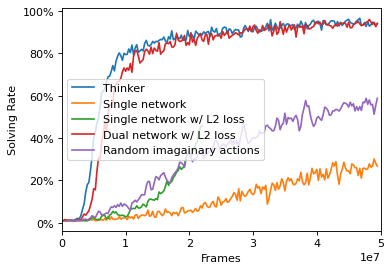

In [119]:
results = {
    "Thinker": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2", "v13_0.7b6_r3", "v13_0.7b6_r4"],
    "Single network": ["v13_0.7b6_noduel_r1", "v13_0.7b6_noduel_r2", "v13_0.7b6_noduel_r3"],    
    "Single network w/ L2 loss": ["noduel_base_l2obs_8"],    
    "Dual network w/ L2 loss": ["v13_0.7b6_dirloss", "v13_0.7b6_dirloss_r2", "v13_0.7b6_dirloss_r3"],  
    "Random imagainary actions": ["v13_0.7b6_randim"],    
}
saveimg = None

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []    
    max_len = 0
    for n, r in enumerate(rs):        
        new_y = scores_sokoban[r][1]        
        if n == 0:
            max_len = len(new_y)
        else:
            new_y = new_y[:max_len]
        y.append(new_y)
    ys.append(np.array(y))    
    ys[-1] = ys[-1] + 0.01 
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)
    for thres in [2e7, 5e7-1e6]:
        ind = np.argmax(np.array(xs[-1]) >= thres)
        mean = np.average(ys[-1][:, ind])
        print("%s \t %d \t %4f" % (label, int(thres), mean))
saveimg = "/home/schk/rebuttal/a3_.pdf"
plot(xs, ys, labels, mv_ns=[1,1,3,1,3], saveimg=saveimg, xlim=5e7, legend=True, plot_std=False)        

Thinker 	 20000000 	 0.880312
Thinker 	 49000000 	 0.945937
Random imagainary actions 	 20000000 	 0.322500
Random imagainary actions 	 49000000 	 0.478750


<Axes: xlabel='Frames', ylabel='Solving Rate'>

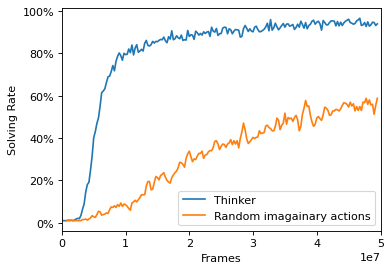

In [79]:
results = {
    "Thinker": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2", "v13_0.7b6_r3", "v13_0.7b6_r4"],  
    "Random imagainary actions": ["v13_0.7b6_randim"],   
}
saveimg = None

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []    
    max_len = 0
    for n, r in enumerate(rs):        
        new_y = scores_sokoban[r][1]        
        if n == 0:
            max_len = len(new_y)
        else:
            new_y = new_y[:max_len]
        y.append(new_y)
    ys.append(np.array(y))    
    ys[-1] = ys[-1] + 0.01 
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)
    for thres in [2e7, 5e7-1e6]:
        ind = np.argmax(np.array(xs[-1]) >= thres)
        mean = np.average(ys[-1][:, ind])
        print("%s \t %d \t %4f" % (label, int(thres), mean))

plot(xs, ys, labels, mv_ns=[1, 3], saveimg=saveimg, xlim=5e7, legend=True, plot_std=False)           

Run 1 	 20000000 	 0.900625
Run 1 	 49000000 	 0.924063
Run 2 	 20000000 	 0.838125
Run 2 	 49000000 	 0.939688
Run 3 	 20000000 	 0.885000
Run 3 	 49000000 	 0.916250
Run 4 	 20000000 	 0.885000
Run 4 	 49000000 	 0.970938
Run 5 	 20000000 	 0.892813
Run 5 	 49000000 	 0.978750


<Axes: xlabel='Frames', ylabel='Solving Rate'>

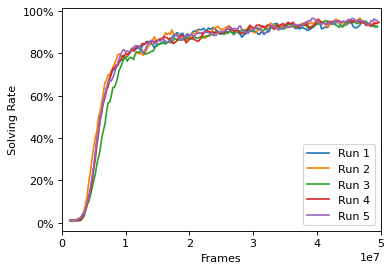

In [111]:
results = {
    "Run 1": ["v13_0.7b6"],
    "Run 2": ["v13_0.7b6_r1"], 
    "Run 3": ["v13_0.7b6_r2"], 
    "Run 4": ["v13_0.7b6_r3"], 
    "Run 5": ["v13_0.7b6_r4"],
}
saveimg = "/home/schk/rebuttal/a4.pdf"
xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []    
    max_len = 0
    for n, r in enumerate(rs):        
        new_y = scores_sokoban[r][1]        
        if n == 0:
            max_len = len(new_y)
        else:
            new_y = new_y[:max_len]
        y.append(new_y)
    ys.append(np.array(y))    
    ys[-1] = ys[-1] + 0.01 
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)
    for thres in [2e7, 5e7-1e6]:
        ind = np.argmax(np.array(xs[-1]) >= thres)
        mean = np.average(ys[-1][:, ind])
        print("%s \t %d \t %4f" % (label, int(thres), mean))

plot(xs, ys, labels, mv_ns=[5,5,5,5,5], saveimg=saveimg, xlim=5e7, legend=True, plot_std=False)           

In [33]:
def read_run(path, mean_n=200, log_freq=250000, tran=False):
    with open(os.path.join(path, "meta.json"), "r") as f:
        flags = Namespace(**json.load(f)["args"])
    max_actor_id = (
        flags.gpu_num_actors * flags.gpu_num_p_actors
        + flags.cpu_num_actors * flags.cpu_num_p_actors
    )
    print("Reading %s max_actor_id %d" % (run, max_actor_id))
    ret_buffer = RetBuffer(max_actor_id, mean_n)
    csv_file = os.path.join(path, "logs.csv")
    step = log_freq
    steps, returns = [], []
    with open(csv_file, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            done_ids = eval(row["done_ids"])
            episode_returns = eval(row["episode_returns"])
            if tran:
                episode_returns = tuple(float(r > 10) for r in episode_returns)
            ret_buffer.insert(episode_returns, done_ids)
            if eval(row["real_step"]) >= step:
                steps.append(step)
                returns.append(ret_buffer.get_mean())
                step += log_freq
    return steps, returns

runs = [
    "v13_0.7b6_norew",
    "v13_0.7b6_novpi",
    "v13_b_0.7b6",
    "v13_b_0.7b6_r1",
    "v13_b_0.7b6_r2",
    "v13_0.7b6_randim",
    "v13_0.7b6_dirloss",
    "v13_0.7b6_dirloss_r2",
    "v13_0.7b6_dirloss_r3",
    "v13_0.7b6_noduel_r1",
    "v13_0.7b6_noduel_r2",
    "v13_0.7b6_noduel_r3",
    "noduel_base_l2obs_8",
    "v13_0.7b6_noimg"
]
log_path = "/home/schk/rebuttal/logs"
for run in runs:
    #path = os.path.join(log_path, run, "logs.csv")
    path = os.path.join(log_path, run)
    scores_sokoban[run] = read_run(path, mean_n=200, tran=True)

Reading v13_0.7b6_noimg max_actor_id 64


Default 	 20000000 	 0.864583
Default 	 49000000 	 0.916667
Raw MDP 	 20000000 	 0.194010
Raw MDP 	 49000000 	 0.559896
No planning rewards 	 20000000 	 0.894531
No planning rewards 	 49000000 	 0.941406
No values & policies 	 20000000 	 0.003906
No values & policies 	 49000000 	 0.000000
Random imagainary actions 	 20000000 	 0.328125
Random imagainary actions 	 49000000 	 0.539062


<Axes: xlabel='Frames', ylabel='Solving Rate'>

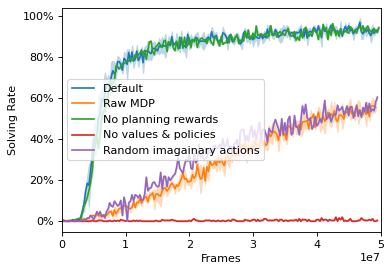

In [28]:
results = {
    "Default": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2"],
    "Raw MDP": ["v13_b_0.7b6_r1", "v13_b_0.7b6_r2", "v13_b_0.7b6"],
    "No planning rewards": ["v13_0.7b6_norew"],
    "No values & policies":["v13_0.7b6_novpi"],
    "Random imagainary actions": ["v13_0.7b6_randim"],   
}
saveimg = None

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []    
    max_len = 0
    for n, r in enumerate(rs):        
        new_y = scores_sokoban[r][1]        
        if n == 0:
            max_len = len(new_y)
        else:
            new_y = new_y[:max_len]
        y.append(new_y)
    ys.append(np.array(y))   
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)
    for thres in [2e7, 5e7-1e6]:
        ind = np.argmax(np.array(xs[-1]) >= thres)
        mean = np.average(ys[-1][:, ind])
        print("%s \t %d \t %4f" % (label, int(thres), mean))
saveimg = "/home/schk/rebuttal/t.pdf"
plot(xs, ys, labels, mv_ns=[1,1,1,1,1], saveimg=saveimg, xlim=5e7, legend=True, plot_std=True)        

Default 	 20000000 	 0.864583
Default 	 49000000 	 0.916667
Single network 	 20000000 	 0.054688
Single network 	 49000000 	 0.289062
Single network and L2 loss 	 20000000 	 0.332031
Single network and L2 loss 	 49000000 	 0.582031
L2 loss 	 20000000 	 0.845052
L2 loss 	 49000000 	 0.932292
No state loss 	 20000000 	 0.000000
No state loss 	 49000000 	 0.023438


<Axes: xlabel='Frames', ylabel='Solving Rate'>

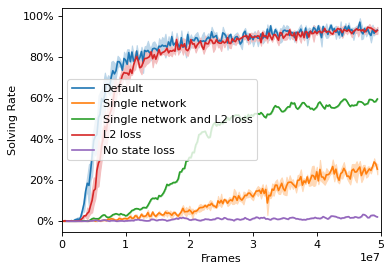

In [34]:
results = {
    "Default": ["v13_0.7b6", "v13_0.7b6_r1", "v13_0.7b6_r2"],
    "Single network": ["v13_0.7b6_noduel_r1", "v13_0.7b6_noduel_r2", "v13_0.7b6_noduel_r3"],    
    "Single network and L2 loss": ["noduel_base_l2obs_8"],    
    "L2 loss": ["v13_0.7b6_dirloss", "v13_0.7b6_dirloss_r2", "v13_0.7b6_dirloss_r3"],  
    "No state loss": ["v13_0.7b6_noimg"]
}
saveimg = None

xs, ys, labels = [], [], []
for label, rs in results.items():
    y = []    
    max_len = 0
    for n, r in enumerate(rs):        
        new_y = scores_sokoban[r][1]        
        if n == 0:
            max_len = len(new_y)
        else:
            new_y = new_y[:max_len]
        y.append(new_y)
    ys.append(np.array(y))    
    xs.append(scores_sokoban[rs[0]][0])
    labels.append(label)
    for thres in [2e7, 5e7-1e6]:
        ind = np.argmax(np.array(xs[-1]) >= thres)
        mean = np.average(ys[-1][:, ind])
        print("%s \t %d \t %4f" % (label, int(thres), mean))
saveimg = "/home/schk/rebuttal/t2.pdf"
plot(xs, ys, labels, mv_ns=[1,1,3,1,3], saveimg=saveimg, xlim=5e7, legend=True, plot_std=True)        